#Set-up

In [ ]:
!pip install shap

In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from joblib import parallel_backend


import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter
import random
random.seed(42)

## Data preparation


In [ ]:
def compute_optimality_gap(data, columns, opt_column):
    for c in columns:
        data[c+"_opt"] = (data[c+"_obj"] - data[opt_column])/data[opt_column]

In [ ]:
features = [f"kpi_{i}" for i in range(1, 18)]
heuristic_names =['DPA', 'LV', 'DS', 'G']

df = pd.read_csv("./dataset/ds_CLSP.csv", delimiter=';', decimal=',')
df_large = pd.read_csv("./dataset/ds_large.csv", delimiter=';', decimal=',')

compute_optimality_gap(df, heuristic_names, 'solver_obj')
compute_optimality_gap(df_large, heuristic_names, 'solver_obj')

# to be deleted ** Fixing the wrong labels
df['lowest_opt_column'] = df[['DPA_opt', 'LV_opt', 'DS_opt', 'G_opt']].idxmin(axis=1)
label_mapping = {'DPA_opt': 0, 'LV_opt': 1, 'DS_opt': 2, 'G_opt': 3}
df['label'] = df['lowest_opt_column'].map(label_mapping)
df = df.drop(['lowest_opt_column'], axis=1)


df['oracle_opt'] = df[['DPA_opt', 'LV_opt', 'DS_opt', 'G_opt']].min(axis=1)
df_large['oracle_opt'] = df_large[['DPA_opt', 'LV_opt', 'DS_opt', 'G_opt']].min(axis=1)

dev_df, test_df = train_test_split(df, train_size=0.8, stratify=df["label"], random_state=16)

# Extract the features but leave as a DataFrame
X_train = dev_df[features]
X_test = test_df[features]

y_train = dev_df["label"]
y_test = test_df["label"]


X_large = df_large[features]
y_large = df_large["label"]


## Classifier comparison

In [ ]:
# Classifiers comparison

# Define the pipeline with StandardScaler
def create_pipeline(classifier):
    steps = [
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ]

    return Pipeline(steps)

# Define the hyperparameter grids for each classifier
param_grids = {
    'rf': {
        'classifier__n_estimators': [200, 300],
        'classifier__max_depth': [3, 5, 10, 20],
        'classifier__min_samples_split': [2, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'svm': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    'knn': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    },
    'xgb': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }
}

# Create a dictionary to map classifiers to their respective classes
classifiers = {
    'rf': RandomForestClassifier(),
    'svm': SVC(),
    'knn': KNeighborsClassifier(),
    'xgb': XGBClassifier()
}

# Iterate over classifiers and perform grid search
for clf_name, clf in classifiers.items():
    print(f"\nGrid Search for {clf_name}:\n")

    # Create the GridSearchCV object with the pipeline
    grid_search = GridSearchCV(create_pipeline(clf), param_grids[clf_name], cv=5, scoring='accuracy')

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and corresponding accuracy score
    print(f"Best Parameters: {grid_search.best_params_}")
    print("Best Accuracy Score: {:.3f}".format(grid_search.best_score_))

    # Evaluate the model on the test set
    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy: {:.3f}".format(test_accuracy))


## Random Forest pipeline

In [ ]:
random.seed(40)

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('rf', RandomForestClassifier())  # Random Forest Classifier
])

# Define the hyperparameter grid for GridSearch


param_grid =  {
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [10, 15, 20, None],
    'rf__min_samples_split': [1, 2,5],
    'rf__min_samples_leaf': [4, 8, 16]
}

param_grid = {'rf__max_depth': [None], 'rf__min_samples_leaf': [4], 'rf__min_samples_split': [5], 'rf__n_estimators': [200]}
# Create the GridSearchCV object
with parallel_backend('threading', n_jobs=3):
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy score
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy Score: {:.3f}".format(grid_search.best_score_))

# Evaluate the model on the test set
y_pred = grid_search.predict(X_test)
test_df['pred_rf'] = y_pred
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.3f}".format(test_accuracy))

# printing and saving the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= heuristic_names)
disp.grid = False
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)
plt.grid(False)
plt.savefig("./img/confusion_matrix.png", dpi=150, bbox_inches= 'tight')
plt.close()

# Evaluate the model on the large test set
y_large_pred = grid_search.predict(X_large)
df_large['pred_rf'] = y_large_pred
test_accuracy = accuracy_score(y_large, y_large_pred)  # Apply sample weights during evaluation
print("Test Accuracy: {:.3f}".format(test_accuracy))

# printing and saving the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_large, y_large_pred), display_labels= heuristic_names)
disp.grid = False
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)
plt.grid(False)
plt.savefig("./img/confusion_matrix_large.png", dpi=150, bbox_inches= 'tight')
plt.close()

In [ ]:
# Sample weights computation
# weight option True = range, False = mean
def compute_sample_weights(data, X, use_mean = True):
    if use_mean:
        s_weights =  [data.loc[x, ["DPA_opt", "LV_opt", "DS_opt", "G_opt"]].mean() for x in X.index]
    else:
        s_weights =  [data.loc[x, ["DPA_opt", "LV_opt", "DS_opt", "G_opt"]].max() - dev_df.loc[x, ["DPA_opt", "LV_opt", "DS_opt", "G_opt"]].min() for x in X.index]

    if min(s_weights)<=0:
        s_weights -= min(s_weights)-0.001
    return s_weights

In [ ]:

# Fit the GridSearchCV object to the training data
sample_weights = compute_sample_weights(dev_df,X_train,False)

grid_search.fit(X_train, y_train, rf__sample_weight = sample_weights)

# Print the best parameters and corresponding accuracy score
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy Score: {:.3f}".format(grid_search.best_score_))

# Evaluate the model on the test set
y_pred_cs = grid_search.predict(X_test)
test_df['pred_rf_cs'] = y_pred_cs
test_accuracy = accuracy_score(y_test, y_pred_cs)  # Apply sample weights during evaluation
print("Test Accuracy: {:.3f}".format(test_accuracy))

# printing and saving the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_cs), display_labels= heuristic_names)
disp.grid = False
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)
plt.grid(False)
plt.savefig("./img/confusion_matrix_cs.png", dpi=150, bbox_inches= 'tight')
plt.close()

# Evaluate the model on the large test set
y_large_pred_cs = grid_search.predict(X_large)
df_large['pred_rf_cs'] = y_large_pred_cs
test_accuracy = accuracy_score(y_large, y_large_pred_cs)  # Apply sample weights during evaluation
print("Test Accuracy: {:.3f}".format(test_accuracy))

# printing and saving the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_large, y_large_pred_cs), display_labels= heuristic_names)
disp.grid = False
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)
plt.grid(False)
plt.savefig("./img/confusion_matrix_large_cs.png", dpi=150, bbox_inches= 'tight')


# Feature Selection

In [ ]:
def feature_importance_accuracy_plot(pipeline, grid_search, f_list, X, y, s_weights = None):
    X= X[f_list]
    with parallel_backend('threading', n_jobs=3):

        if s_weights is None:
            pipeline.fit(X,y)
        else:
            pipeline.fit(X,y, rf__sample_weight=s_weights)

        feature_importances = pipeline['rf'].feature_importances_
        print(feature_importances)
        feature_importance_dict = dict(zip(f_list, feature_importances))
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        explainer = shap.TreeExplainer(pipeline['rf'])
        shap_values = explainer.shap_values(X)
        shap.summary_plot(shap_values, X,   feature_names=f_list, class_names=heuristic_names, plot_size=[12,7], show= False)
        plt.savefig("./img/feature_relevance_" + str(len(f_list)) + ".png", dpi=150)
        plt.close()
        # for feature, importance in sorted_feature_importance:
        #     print(f"{feature}: {importance}")
        portfolio=[]
        # Create a list of feature subset of increasing size and importance
        for feature, importance in sorted_feature_importance:
            if len(portfolio)==0:
                portfolio.append([feature])
            else:
                temp=portfolio[-1]
                portfolio.append(temp+[feature])

        kfold_accuracies=[]
        mean_scores=[]
        for selected_features in portfolio:
            print(len(selected_features),"out of ", len(portfolio) ,"\r")

            # Extract the selected features
            X_subset = X_train[selected_features]

            stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=16)
            cv_scores = cross_val_score(grid_search, X_subset, y_train, cv=stratified_kfold, scoring='accuracy')

            kfold_accuracies.append(cv_scores)

            # Calculate the mean accuracy from cross-validation
            mean_accuracy = cv_scores.mean()

            # Store the result as (feature count, accuracy)
            mean_scores.append((len(selected_features), mean_accuracy))
        combined_data = [[min(vals), max(vals)] for vals in kfold_accuracies]
        feature_counts, kfold_mean_accuracies  = zip(*mean_scores)
        # creating a dictionary
        font = {'size': 14}

        # using rc function
        plt.rc('font', **font)

        plt.plot(feature_counts, kfold_mean_accuracies, color='b', label='Accuracy', marker='o')
        for i in range(len(kfold_accuracies)):

            plt.vlines(i+1, min(kfold_accuracies[i]),max(kfold_accuracies[i]), color='g', label='ranges',linestyle='-', lw=2)
            plt.hlines(y=min(kfold_accuracies[i]), xmin=i+0.8, xmax=i+1.2, color='g', linestyle='-', lw=2)
            plt.hlines(y=max(kfold_accuracies[i]), xmin=i+0.8, xmax=i+1.2, color='g', linestyle='-', lw=2)
        plt.xlabel('Selected Features')
        plt.ylabel('Accuracy')

        custom_labels = [s.lstrip('kpi_') for s in portfolio[-1]]

        plt.xticks( range(min(feature_counts), max(feature_counts) + 1), custom_labels, rotation=45, ha='right')
        plt.xlim(1, max(feature_counts) + 1)
        plt.ylim(0.4, 0.9)
        plt.subplots_adjust(bottom=0.2)

        plt.savefig("./img/feature_importance_overclassification" + str(len(f_list)) + ".eps", format='eps')


        plt.show()
        plt.close()

    return portfolio

In [ ]:
random.seed(42)
portfolio = feature_importance_accuracy_plot(pipeline, grid_search, features, X_train, y_train)

In [ ]:
print(portfolio[6])

In [ ]:
print(portfolio[6])
portfolio = feature_importance_accuracy_plot(pipeline, grid_search, portfolio[6], X_train, y_train)

In [ ]:
print(portfolio[2])
portfolio = feature_importance_accuracy_plot(pipeline, grid_search, portfolio[2], X_train, y_train)

In [ ]:
random.seed(42)
final_kpi = portfolio[-1]

# final_kpi = ['kpi_17', 'kpi_12', 'kpi_8']

X_train_fs = X_train[final_kpi]
X_test_fs = X_test[final_kpi]
X_large_fs = X_large[final_kpi]

# Define the pipeline
pipeline_fs = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('rf', RandomForestClassifier())  # Random Forest Classifier
])

# Define the hyperparameter grid for GridSearch
param_grid =  {
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [5, 7, 10, 20, None],
    'rf__min_samples_split': [ 2, 10],
    'rf__min_samples_leaf': [2, 4, 8]
}

# param_grid = {'rf__max_depth': [20], 'rf__min_samples_leaf': [8], 'rf__min_samples_split': [2], 'rf__n_estimators': [200]}
# Create the GridSearchCV object
grid_search_fs = GridSearchCV(pipeline_fs, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search_fs.fit(X_train_fs, y_train)

# Print the best parameters and corresponding accuracy score
print("Best Parameters: ", grid_search_fs.best_params_)
print("Best Accuracy Score: {:.3f}".format(grid_search_fs.best_score_))



# Evaluate the model on the test set
y_pred_cs_fs = grid_search_fs.predict(X_test_fs)
test_df['pred_rf_cs_fs'] = y_pred_cs_fs
test_accuracy = accuracy_score(y_test, y_pred_cs_fs)  # Apply sample weights during evaluation
print("Test Accuracy: {:.3f}".format(test_accuracy))



# printing and saving the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_cs_fs), display_labels= heuristic_names)
disp.grid = False
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)
plt.grid(False)
plt.savefig("./img/confusion_matrix_cs_fs.png", dpi=150, bbox_inches= 'tight')
plt.close()

# Evaluate the model on the large test set
y_large_pred_cs_fs = grid_search_fs.predict(X_large_fs)
df_large['pred_rf_cs_fs'] = y_large_pred_cs_fs
test_accuracy = accuracy_score(y_large, y_large_pred_cs_fs)  # Apply sample weights during evaluation
print("Test Accuracy Large: {:.3f}".format(test_accuracy))

# printing and saving the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_large, y_large_pred_cs_fs), display_labels= heuristic_names)
disp.grid = False
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)
plt.grid(False)
plt.savefig("./img/confusion_matrix_large_cs_fs.png", dpi=150, bbox_inches= 'tight')
plt.close()



In [ ]:

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_large_scaled = scaler.transform(X_large)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=4)
y_test_onehot = to_categorical(y_test, num_classes=4)

# Define the model
model = Sequential()

# Input layer with StandardScaler
model.add(BatchNormalization(input_shape=(17,)))

# First hidden layer
model.add(Dense(16, activation='relu'))

# Dropout layer
model.add(Dropout(0.05))

# Second hidden layer
model.add(Dense(16, activation='relu'))

# Another Dropout layer
model.add(Dropout(0.05))

model.add(Dense(4, activation='softmax'))

# Compile the model
learning_rate = 0.002
optimizer = RMSprop(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()

history = model.fit(X_train_scaled, y_train_onehot, epochs=1000, batch_size=512, validation_split=0.1)


In [ ]:
# Evaluate the model on the test set
y_pred_onehot = model.predict(X_test_scaled)
y_pred_nn = np.argmax(y_pred_onehot, axis=1)

test_df['pred_nn'] = y_pred_nn
test_accuracy = accuracy_score(y_test, y_pred_nn)  # Apply sample weights during evaluation
print("Test Accuracy: {:.3f}".format(test_accuracy))



# Evaluate the model on the large test set
y_pred_onehot = model.predict(X_large_scaled)
y_large_pred_nn = np.argmax(y_pred_onehot, axis=1)
df_large['pred_nn'] = y_large_pred_nn
test_accuracy = accuracy_score(y_large, y_large_pred_nn)  # Apply sample weights during evaluation
print("Test Accuracy Large: {:.3f}".format(test_accuracy))

In [ ]:
def calculate_predicted_opt(data, prediction_column, prediction_label):
    data[prediction_label] = 0
    for index, row in data.iterrows():
        data.loc[index, prediction_label]= row[heuristic_names[row[prediction_column]]+"_opt"]
    return data

predictions = ['pred_rf', 'pred_rf_cs_fs', 'pred_nn', 'label']
opt_columns = ['rf_opt', 'rf_cs_fs_opt', 'nn_opt',  'oracle_opt']
display_columns = ['DPA_opt', 'LV_opt', 'DS_opt', 'G_opt'] +opt_columns

for p, o in zip(predictions, opt_columns):
    calculate_predicted_opt(test_df,p, o)

test_df[display_columns].describe()

In [ ]:
results = test_df[display_columns].describe()*100
results.columns = display_columns
print(results.loc[['mean', 'min', '25%','50%','75%', 'max']].round(2).to_latex())

In [ ]:

for p, o in zip(predictions, opt_columns):
    calculate_predicted_opt(df_large,p, o)

df_large[display_columns].describe()

In [ ]:
results = df_large[display_columns].describe()*100
results.columns = display_columns
print(results.loc[['mean','50%', 'max']].round(2).to_latex())

##With Feature Selection

In [ ]:
final_kpi

In [ ]:
random.seed(11)
features_name = [s.lstrip('kpi_') for s in final_kpi]
explainer = shap.TreeExplainer(grid_search_fs.best_estimator_['rf'])
shap_values = explainer.shap_values(X_test_fs)
# creating a dictionary
font = {'size': 30}

# using rc function
plt.rc('font', **font)
shap.summary_plot(shap_values, X_test_fs,   feature_names=features_name, class_names=heuristic_names, plot_size=[12,7], show= False)

plt.savefig("./img/feature_relevance_" + str(len(final_kpi)) + ".png", dpi=150)
plt.close()

for i, c in enumerate(heuristic_names):
    # create the shap plot

    # using rc function
    plt.rc('font', **font)
    shap.summary_plot(shap_values[i], X_test_fs,plot_size=[6,6], feature_names=features_name, class_names=heuristic_names, show= False, title= "Feature relevance for " + c + ".png")
    # saving it as a picture
    plt.savefig("./img/feature_importance_test_set_" + c + ".png", dpi=150)
    plt.close()

In [ ]:
random.seed(11)


explainer = shap.TreeExplainer(grid_search_fs.best_estimator_['rf'])
shap_values = explainer.shap_values(X_large_fs)
plt.rc('font', **font)

shap.summary_plot(shap_values, X_large_fs,   feature_names=features_name, class_names=heuristic_names, plot_size=[12,7], show= False)
plt.savefig("./img/feature_relevance_" + str(len(final_kpi)) + ".png", dpi=150)
plt.close()

for i, c in enumerate(heuristic_names):
    # create the shap plot
    plt.rc('font', **font)

    shap.summary_plot(shap_values[i], X_large_fs,plot_size=[6,6], feature_names=features_name, class_names=heuristic_names, show= False, title= "Feature relevance for " + c + ".png")
    # saving it as a picture
    plt.savefig("./img/feature_importance_large_set_" + c + ".png", dpi=150)
    plt.close()

In [ ]:
plt.figure(figsize=(10, 6))


test_df[display_columns].boxplot()

# Rename the x-axis points
custom_labels = ['DPA', 'LV', 'DS', 'G','AS RF','AS RF CS ','AS NN', 'Oracle']

plt.xticks(range(1, len(display_columns) + 1), custom_labels, rotation=45, ha='right')

# Add axis titles
plt.ylabel('Optimality Gap(%)')
plt.savefig("./img/boxplot_test.eps", format='eps')

In [ ]:
plt.figure(figsize=(10, 6))

df_large[display_columns].boxplot()


plt.xticks(range(1, len(display_columns) + 1), custom_labels, rotation=45, ha='right')

# Add axis titles
plt.ylabel('Optimality Gap(%)')

# Feature Selection

In [9]:
def feature_importance_accuracy_plot(pipeline, grid_search, f_list, X, y, s_weights = None):
    X= X[f_list]
    with parallel_backend('threading', n_jobs=3):

        if s_weights is None:
            pipeline.fit(X,y)
        else:
            pipeline.fit(X,y, rf__sample_weight=s_weights)

        feature_importances = pipeline['rf'].feature_importances_
        print(feature_importances)
        feature_importance_dict = dict(zip(f_list, feature_importances))
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        explainer = shap.TreeExplainer(pipeline['rf'])
        shap_values = explainer.shap_values(X)
        shap.summary_plot(shap_values, X,   feature_names=f_list, class_names=heuristic_names, plot_size=[12,7], show= False)
        plt.savefig("./img/feature_relevance_" + str(len(f_list)) + ".png", dpi=150)
        plt.close()
        # for feature, importance in sorted_feature_importance:
        #     print(f"{feature}: {importance}")
        portfolio=[]
        # Create a list of feature subset of increasing size and importance
        for feature, importance in sorted_feature_importance:
            if len(portfolio)==0:
                portfolio.append([feature])
            else:
                temp=portfolio[-1]
                portfolio.append(temp+[feature])

        kfold_accuracies=[]
        mean_scores=[]
        for selected_features in portfolio:
            print(len(selected_features),"out of ", len(portfolio) ,"\r")

            # Extract the selected features
            X_subset = X_train[selected_features]

            stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=16)
            cv_scores = cross_val_score(grid_search, X_subset, y_train, cv=stratified_kfold, scoring='accuracy')

            kfold_accuracies.append(cv_scores)

            # Calculate the mean accuracy from cross-validation
            mean_accuracy = cv_scores.mean()

            # Store the result as (feature count, accuracy)
            mean_scores.append((len(selected_features), mean_accuracy))
        combined_data = [[min(vals), max(vals)] for vals in kfold_accuracies]
        feature_counts, kfold_mean_accuracies  = zip(*mean_scores)
        # creating a dictionary
        font = {'size': 14}

        # using rc function
        plt.rc('font', **font)

        plt.plot(feature_counts, kfold_mean_accuracies, color='b', label='Accuracy', marker='o')
        for i in range(len(kfold_accuracies)):

            plt.vlines(i+1, min(kfold_accuracies[i]),max(kfold_accuracies[i]), color='g', label='ranges',linestyle='-', lw=2)
            plt.hlines(y=min(kfold_accuracies[i]), xmin=i+0.8, xmax=i+1.2, color='g', linestyle='-', lw=2)
            plt.hlines(y=max(kfold_accuracies[i]), xmin=i+0.8, xmax=i+1.2, color='g', linestyle='-', lw=2)
        plt.xlabel('Selected Features')
        plt.ylabel('Accuracy')

        custom_labels = [s.lstrip('kpi_') for s in portfolio[-1]]

        plt.xticks( range(min(feature_counts), max(feature_counts) + 1), custom_labels, rotation=45, ha='right')
        plt.xlim(1, max(feature_counts) + 1)
        plt.ylim(0.4, 0.9)
        plt.subplots_adjust(bottom=0.2)

        plt.savefig("./img/feature_importance_overclassification" + str(len(f_list)) + ".eps", format='eps')


        plt.show()
        plt.close()

    return portfolio

[0.04491923 0.07199535 0.04151829 0.05691261 0.03995695 0.03788387
 0.03957872 0.04953025 0.05912685 0.03995131 0.06381706 0.07866236
 0.02614502 0.02704756 0.11227504 0.03278534 0.1778942 ]
1 out of  17 
2 out of  17 
3 out of  17 
4 out of  17 
5 out of  17 
6 out of  17 
7 out of  17 
8 out of  17 
9 out of  17 
10 out of  17 
11 out of  17 
12 out of  17 
13 out of  17 
14 out of  17 
15 out of  17 
16 out of  17 
17 out of  17 


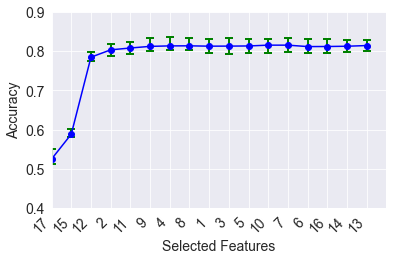

In [10]:
random.seed(42)
portfolio = feature_importance_accuracy_plot(pipeline, grid_search, features, X_train, y_train)

In [11]:
print(portfolio[6])

['kpi_17', 'kpi_15', 'kpi_12', 'kpi_2', 'kpi_11', 'kpi_9', 'kpi_4']


['kpi_17', 'kpi_15', 'kpi_12', 'kpi_2', 'kpi_11', 'kpi_9', 'kpi_4']
[0.21773651 0.14151934 0.14801521 0.14321561 0.12125337 0.11024149
 0.11801847]
1 out of  7 
2 out of  7 
3 out of  7 
4 out of  7 
5 out of  7 
6 out of  7 
7 out of  7 


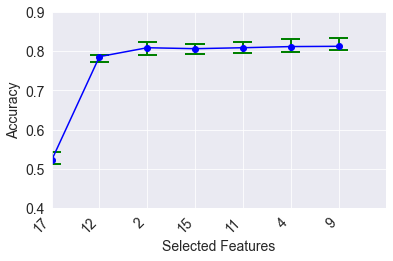

In [12]:
print(portfolio[6])
portfolio = feature_importance_accuracy_plot(pipeline, grid_search, portfolio[6], X_train, y_train)

['kpi_17', 'kpi_12', 'kpi_2']
[0.38666083 0.35483771 0.25850147]
1 out of  3 
2 out of  3 
3 out of  3 


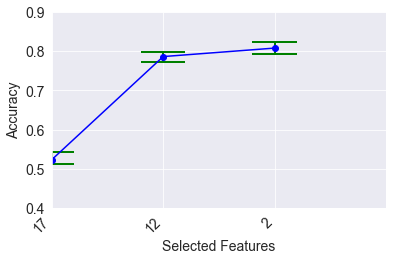

In [13]:
print(portfolio[2])
portfolio = feature_importance_accuracy_plot(pipeline, grid_search, portfolio[2], X_train, y_train)

In [14]:
random.seed(42)
final_kpi = portfolio[-1]

# final_kpi = ['kpi_17', 'kpi_12', 'kpi_8']

X_train_fs = X_train[final_kpi]
X_test_fs = X_test[final_kpi]
X_large_fs = X_large[final_kpi]

# Define the pipeline
pipeline_fs = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('rf', RandomForestClassifier())  # Random Forest Classifier
])

# Define the hyperparameter grid for GridSearch
param_grid =  {
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [5, 7, 10, 20, None],
    'rf__min_samples_split': [ 2, 10],
    'rf__min_samples_leaf': [2, 4, 8]
}

# param_grid = {'rf__max_depth': [20], 'rf__min_samples_leaf': [8], 'rf__min_samples_split': [2], 'rf__n_estimators': [200]}
# Create the GridSearchCV object
grid_search_fs = GridSearchCV(pipeline_fs, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search_fs.fit(X_train_fs, y_train)

# Print the best parameters and corresponding accuracy score
print("Best Parameters: ", grid_search_fs.best_params_)
print("Best Accuracy Score: {:.3f}".format(grid_search_fs.best_score_))



# Evaluate the model on the test set
y_pred_cs_fs = grid_search_fs.predict(X_test_fs)
test_df['pred_rf_cs_fs'] = y_pred_cs_fs
test_accuracy = accuracy_score(y_test, y_pred_cs_fs)  # Apply sample weights during evaluation
print("Test Accuracy: {:.3f}".format(test_accuracy))



# printing and saving the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_cs_fs), display_labels= heuristic_names)
disp.grid = False
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)
plt.grid(False)
plt.savefig("./img/confusion_matrix_cs_fs.png", dpi=150, bbox_inches= 'tight')
plt.close()

# Evaluate the model on the large test set
y_large_pred_cs_fs = grid_search_fs.predict(X_large_fs)
df_large['pred_rf_cs_fs'] = y_large_pred_cs_fs
test_accuracy = accuracy_score(y_large, y_large_pred_cs_fs)  # Apply sample weights during evaluation
print("Test Accuracy Large: {:.3f}".format(test_accuracy))

# printing and saving the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_large, y_large_pred_cs_fs), display_labels= heuristic_names)
disp.grid = False
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)
plt.grid(False)
plt.savefig("./img/confusion_matrix_large_cs_fs.png", dpi=150, bbox_inches= 'tight')
plt.close()



Best Parameters:  {'rf__max_depth': 20, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best Accuracy Score: 0.811
Test Accuracy: 0.785
Test Accuracy Large: 0.750


In [15]:

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_large_scaled = scaler.transform(X_large)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=4)
y_test_onehot = to_categorical(y_test, num_classes=4)

# Define the model
model = Sequential()

# Input layer with StandardScaler
model.add(BatchNormalization(input_shape=(17,)))

# First hidden layer
model.add(Dense(16, activation='relu'))

# Dropout layer
model.add(Dropout(0.05))

# Second hidden layer
model.add(Dense(16, activation='relu'))

# Another Dropout layer
model.add(Dropout(0.05))

model.add(Dense(4, activation='softmax'))

# Compile the model
learning_rate = 0.002
optimizer = RMSprop(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()

history = model.fit(X_train_scaled, y_train_onehot, epochs=1000, batch_size=512, validation_split=0.1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 17)                68        
_________________________________________________________________
dense (Dense)                (None, 16)                288       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 696
Trainable params: 662
Non-trainable params: 34
_________________________________________________________

In [16]:
# Evaluate the model on the test set
y_pred_onehot = model.predict(X_test_scaled)
y_pred_nn = np.argmax(y_pred_onehot, axis=1)

test_df['pred_nn'] = y_pred_nn
test_accuracy = accuracy_score(y_test, y_pred_nn)  # Apply sample weights during evaluation
print("Test Accuracy: {:.3f}".format(test_accuracy))



# Evaluate the model on the large test set
y_pred_onehot = model.predict(X_large_scaled)
y_large_pred_nn = np.argmax(y_pred_onehot, axis=1)
df_large['pred_nn'] = y_large_pred_nn
test_accuracy = accuracy_score(y_large, y_large_pred_nn)  # Apply sample weights during evaluation
print("Test Accuracy Large: {:.3f}".format(test_accuracy))

Test Accuracy: 0.810
Test Accuracy Large: 0.750


In [17]:
def calculate_predicted_opt(data, prediction_column, prediction_label):
    data[prediction_label] = 0
    for index, row in data.iterrows():
        data.loc[index, prediction_label]= row[heuristic_names[row[prediction_column]]+"_opt"]
    return data

predictions = ['pred_rf', 'pred_rf_cs_fs', 'pred_nn', 'label']
opt_columns = ['rf_opt', 'rf_cs_fs_opt', 'nn_opt',  'oracle_opt']
display_columns = ['DPA_opt', 'LV_opt', 'DS_opt', 'G_opt'] +opt_columns

for p, o in zip(predictions, opt_columns):
    calculate_predicted_opt(test_df,p, o)

test_df[display_columns].describe()

,DPA_opt,LV_opt,DS_opt,G_opt,rf_opt,rf_cs_fs_opt,nn_opt,oracle_opt
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,0.049058,0.089962,0.035998,0.052110,0.022902,0.023193,0.022662,0.020224
std,0.079479,0.095001,0.087218,0.106487,0.042517,0.043176,0.042094,0.027574
min,-0.006140,-0.005330,-0.003772,-0.004342,-0.006140,-0.006140,-0.006140,-0.006140
25%,0.001356,0.017558,0.003315,0.004334,0.000585,0.000578,0.000595,0.000299
50%,0.016952,0.067570,0.015504,0.018184,0.012581,0.012766,0.012355,0.011517
75%,0.059243,0.138887,0.039923,0.050848,0.030709,0.030830,0.030525,0.028915
max,0.484557,0.990414,1.883807,1.883807,1.080204,1.080204,1.080204,0.282176


In [19]:
results = test_df[display_columns].describe()*100
results.columns = display_columns
print(results.loc[['mean', 'min', '25%','50%','75%', 'max']].round(2).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  DPA\_opt &  LV\_opt &  DS\_opt &   G\_opt &  rf\_opt &  rf\_cs\_fs\_opt &  nn\_opt &  oracle\_opt \\
\midrule
mean &     4.91 &    9.00 &    3.60 &    5.21 &    2.29 &          2.32 &    2.27 &        2.02 \\
min  &    -0.61 &   -0.53 &   -0.38 &   -0.43 &   -0.61 &         -0.61 &   -0.61 &       -0.61 \\
25\%  &     0.14 &    1.76 &    0.33 &    0.43 &    0.06 &          0.06 &    0.06 &        0.03 \\
50\%  &     1.70 &    6.76 &    1.55 &    1.82 &    1.26 &          1.28 &    1.24 &        1.15 \\
75\%  &     5.92 &   13.89 &    3.99 &    5.08 &    3.07 &          3.08 &    3.05 &        2.89 \\
max  &    48.46 &   99.04 &  188.38 &  188.38 &  108.02 &        108.02 &  108.02 &       28.22 \\
\bottomrule
\end{tabular}



In [20]:

for p, o in zip(predictions, opt_columns):
    calculate_predicted_opt(df_large,p, o)

df_large[display_columns].describe()

,DPA_opt,LV_opt,DS_opt,G_opt,rf_opt,rf_cs_fs_opt,nn_opt,oracle_opt
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,0.043680,0.097439,0.030883,0.059733,0.020609,0.020943,0.020837,0.019142
std,0.067302,0.093973,0.062810,0.112845,0.031017,0.031607,0.031503,0.028569
min,-0.003114,-0.001806,-0.002715,-0.001960,-0.003114,-0.003114,-0.003114,-0.003114
25%,0.001586,0.010554,0.001923,0.003648,0.000839,0.000812,0.000839,0.000613
50%,0.012505,0.079514,0.010417,0.011983,0.007284,0.007355,0.007515,0.007249
75%,0.064183,0.162444,0.040198,0.055700,0.026840,0.026840,0.027784,0.026158
max,0.422522,0.491825,0.843239,0.843239,0.194817,0.194817,0.194817,0.192591


In [21]:
results = df_large[display_columns].describe()*100
results.columns = display_columns
print(results.loc[['mean','50%', 'max']].round(2).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  DPA\_opt &  LV\_opt &  DS\_opt &  G\_opt &  rf\_opt &  rf\_cs\_fs\_opt &  nn\_opt &  oracle\_opt \\
\midrule
mean &     4.37 &    9.74 &    3.09 &   5.97 &    2.06 &          2.09 &    2.08 &        1.91 \\
50\%  &     1.25 &    7.95 &    1.04 &   1.20 &    0.73 &          0.74 &    0.75 &        0.72 \\
max  &    42.25 &   49.18 &   84.32 &  84.32 &   19.48 &         19.48 &   19.48 &       19.26 \\
\bottomrule
\end{tabular}



##With Feature Selection

In [22]:
final_kpi

['kpi_17', 'kpi_12', 'kpi_2']

In [23]:
random.seed(11)
features_name = [s.lstrip('kpi_') for s in final_kpi]
explainer = shap.TreeExplainer(grid_search_fs.best_estimator_['rf'])
shap_values = explainer.shap_values(X_test_fs)
# creating a dictionary
font = {'size': 30}

# using rc function
plt.rc('font', **font)
shap.summary_plot(shap_values, X_test_fs,   feature_names=features_name, class_names=heuristic_names, plot_size=[12,7], show= False)

plt.savefig("./img/feature_relevance_" + str(len(final_kpi)) + ".png", dpi=150)
plt.close()

for i, c in enumerate(heuristic_names):
    # create the shap plot

    # using rc function
    plt.rc('font', **font)
    shap.summary_plot(shap_values[i], X_test_fs,plot_size=[6,6], feature_names=features_name, class_names=heuristic_names, show= False, title= "Feature relevance for " + c + ".png")
    # saving it as a picture
    plt.savefig("./img/feature_importance_test_set_" + c + ".png", dpi=150)
    plt.close()

In [24]:
random.seed(11)


explainer = shap.TreeExplainer(grid_search_fs.best_estimator_['rf'])
shap_values = explainer.shap_values(X_large_fs)
plt.rc('font', **font)

shap.summary_plot(shap_values, X_large_fs,   feature_names=features_name, class_names=heuristic_names, plot_size=[12,7], show= False)
plt.savefig("./img/feature_relevance_" + str(len(final_kpi)) + ".png", dpi=150)
plt.close()

for i, c in enumerate(heuristic_names):
    # create the shap plot
    plt.rc('font', **font)

    shap.summary_plot(shap_values[i], X_large_fs,plot_size=[6,6], feature_names=features_name, class_names=heuristic_names, show= False, title= "Feature relevance for " + c + ".png")
    # saving it as a picture
    plt.savefig("./img/feature_importance_large_set_" + c + ".png", dpi=150)
    plt.close()

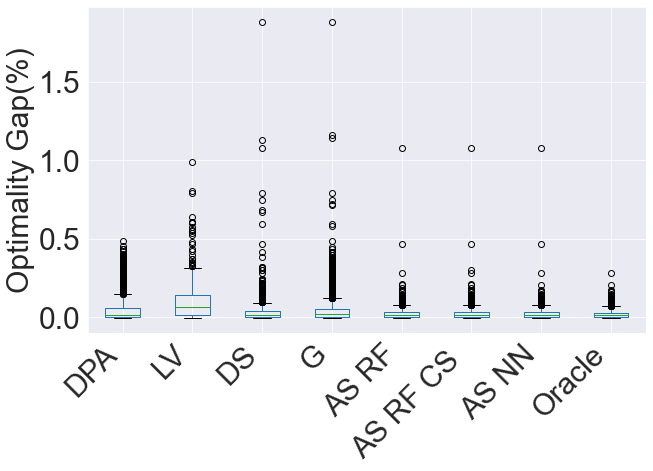

In [25]:
plt.figure(figsize=(10, 6))


test_df[display_columns].boxplot()

# Rename the x-axis points
custom_labels = ['DPA', 'LV', 'DS', 'G','AS RF','AS RF CS ','AS NN', 'Oracle']

plt.xticks(range(1, len(display_columns) + 1), custom_labels, rotation=45, ha='right')

# Add axis titles
plt.ylabel('Optimality Gap(%)')
plt.savefig("./img/boxplot_test.eps", format='eps')

Text(0, 0.5, 'Optimality Gap(%)')

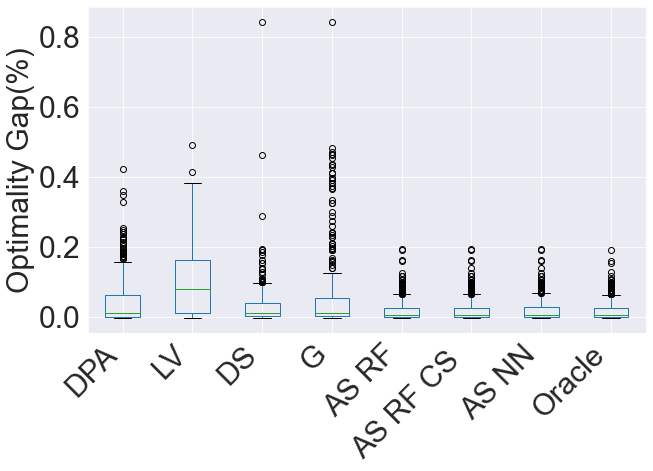

In [26]:
plt.figure(figsize=(10, 6))

df_large[display_columns].boxplot()


plt.xticks(range(1, len(display_columns) + 1), custom_labels, rotation=45, ha='right')

# Add axis titles
plt.ylabel('Optimality Gap(%)')